<a href="https://colab.research.google.com/github/ma55530/SemEval2026-CLARITY-FER/blob/main/hierarchiral/TwoLayeredBinary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing the necessary libraries**

In [1]:
pip -q install scikit-learn torch pandas datasets transformers torchvision accelerate

In [2]:
import pandas as pd
from datasets import Dataset, load_dataset
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments


# **Loading the data**

In [3]:
print("Loading dataset...")
df = load_dataset("ailsntua/QEvasion")

def clarity_to_label(row):
    mapping = {
        "Clear Reply": 0,
        "Ambivalent": 1,
        "Clear Non-Reply": 2
    }
    row["label"] = mapping[row["clarity_label"]]

    # --- FIXED SHORT/LONG BINARY LABEL ---
    answer = row["interview_answer"]
    row["binary_label"] = 0 if (row["clarity_label"] == 0 or row["clarity_label"] == 1) else 1
    return row

df = df.map(clarity_to_label)
y_test = df["test"]["label"]


Loading dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/3.90M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/259k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3448 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/308 [00:00<?, ? examples/s]

Map:   0%|          | 0/3448 [00:00<?, ? examples/s]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

# **Defining the evaluation**

In [4]:
def evaluate(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.show()

def compute_metrics_binary(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "precision": precision_score(labels, preds, average='binary', zero_division=0),
        "recall": recall_score(labels, preds, average='binary', zero_division=0),
        "f1": f1_score(labels, preds, average='binary', zero_division=0)
    }

def compute_metrics_fine(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "precision": precision_score(labels, preds, average='macro', zero_division=0),
        "recall": recall_score(labels, preds, average='macro', zero_division=0),
        "f1": f1_score(labels, preds, average='macro', zero_division=0)
    }


# **Loading the model and tokenizer**

In [5]:


binary_model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2
)

fine_model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2
)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize(example):
    encoded = tokenizer(
        "Question: " + example["interview_question"] +
        " Answer: " + example["interview_answer"],
        padding="max_length",
        max_length=512,
        truncation=True
    )
    encoded["label"] = example["label"]
    encoded["binary_label"] = example["binary_label"]
    return encoded

tokenized_train = df["train"].map(tokenize)
tokenized_test = df["test"].map(tokenize)

cols_to_remove = ["interview_question", "interview_answer", "clarity_label"]

tokenized_train = tokenized_train.remove_columns(cols_to_remove)
tokenized_test  = tokenized_test.remove_columns(cols_to_remove)

tokenized_train.set_format("torch")
tokenized_test.set_format("torch")



config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/3448 [00:00<?, ? examples/s]

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

# **Preparing the data for training**

In [6]:

binary_train = tokenized_train.remove_columns(["label"]).rename_column("binary_label", "labels")
binary_test  = tokenized_test.remove_columns(["label"]).rename_column("binary_label", "labels")

train_fine = tokenized_train.filter(lambda x: x["label"] in [0, 1])
test_fine = tokenized_test.filter(lambda x: x["label"] in [0, 1])

# Check if the datasets are empty
print(f"Size of train_fine: {len(train_fine)}")
print(f"Size of test_fine: {len(test_fine)}")

train_fine = train_fine.rename_column("label", "labels")
test_fine  = test_fine.rename_column("label", "labels")




labels_np = np.array(df["train"]["label"])
class_weights_np = compute_class_weight("balanced", classes=np.unique(labels_np), y=labels_np)
class_weights = torch.tensor(class_weights_np, dtype=torch.float)
print("Class weights:", class_weights)

print(set(train_fine["labels"]))





Filter:   0%|          | 0/3448 [00:00<?, ? examples/s]

Filter:   0%|          | 0/308 [00:00<?, ? examples/s]

Size of train_fine: 3092
Size of test_fine: 285
Class weights: tensor([1.0925, 0.5634, 3.2285])
{tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), tensor(0), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(1), tensor(0), tensor(1), tensor(1), tensor(0), tensor(1), tensor(0), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), t

# **Defining the evaluation function and training**

In [7]:
os.environ["WANDB_DISABLED"] = "true"

class WeightedTrainer(Trainer):
    def __init__(self, weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.weights = weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs["labels"]
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fct = torch.nn.CrossEntropyLoss(weight=self.weights.to(model.device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss



trainer_binary = WeightedTrainer(
    weights=torch.tensor([1.0, 1.0]),
    model=binary_model,
    train_dataset=binary_train,
    eval_dataset=binary_test,
    compute_metrics=compute_metrics_binary,
    args=TrainingArguments(
        output_dir="binary_output",
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        learning_rate=2e-5,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        fp16=True,
        report_to="none"
    ),
)
trainer_binary.train()



Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.000162,1.000000,1.000000,1.000000
2,No log,0.000090,1.000000,1.000000,1.000000
3,0.008800,0.000076,1.000000,1.000000,1.000000


TrainOutput(global_step=648, training_loss=0.006807861248905092, metrics={'train_runtime': 307.0166, 'train_samples_per_second': 33.692, 'train_steps_per_second': 2.111, 'total_flos': 2721620756643840.0, 'train_loss': 0.006807861248905092, 'epoch': 3.0})

In [8]:
trainer_fine = Trainer(
    model=fine_model,
    train_dataset=train_fine,
    eval_dataset=test_fine,
    compute_metrics=compute_metrics_fine,
    args=TrainingArguments(
        output_dir="fine_output_unweighted",
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        learning_rate=2e-5,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        fp16=True,
        report_to="none"
    ),
)

trainer_fine.train()


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.590743,0.659799,0.532168,0.496547
2,No log,0.570869,0.863958,0.512658,0.445959
3,0.602200,0.570025,0.695904,0.615491,0.625956


TrainOutput(global_step=582, training_loss=0.5919169986370912, metrics={'train_runtime': 292.9965, 'train_samples_per_second': 31.659, 'train_steps_per_second': 1.986, 'total_flos': 2440618149519360.0, 'train_loss': 0.5919169986370912, 'epoch': 3.0})

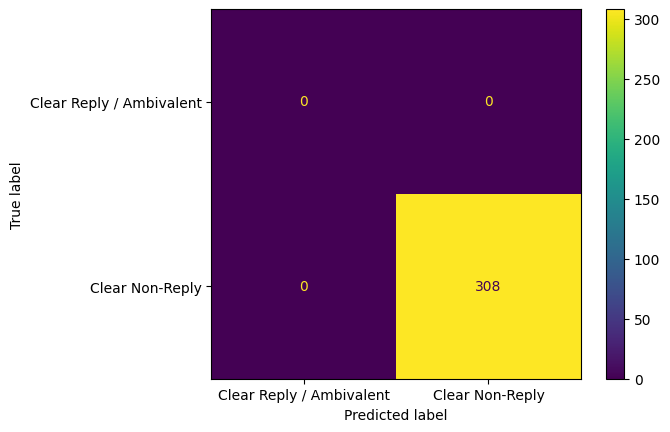

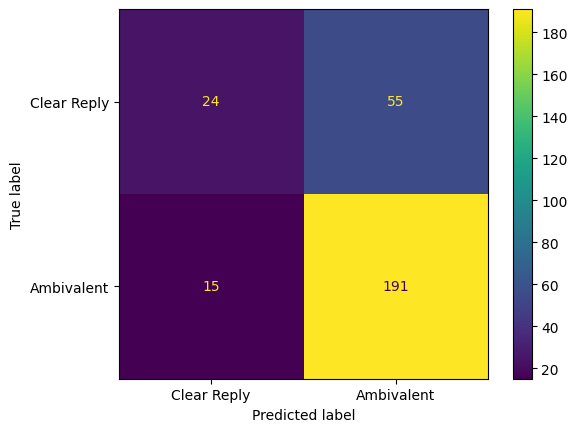

In [11]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import torch
import numpy as np

# --- Funkcija za dvostupanjsko klasificiranje ---
def classify_two_stage(example):
    with torch.no_grad():
        logits = binary_model(**example).logits
    binary_pred = logits.argmax(dim=-1).item()

    if binary_pred == 1:
        return 2  # Clear Non-Reply

    with torch.no_grad():
        logits = fine_model(**example).logits
    fine_pred = logits.argmax(dim=-1).item()
    return fine_pred

# --- Funkcija za plot confusion matrix ---
def plot_cm(trainer, dataset, display_labels):
    predictions = trainer.predict(dataset)
    preds = np.argmax(predictions.predictions, axis=-1)
    labels = predictions.label_ids

    # Dodajemo labels=[0,1] da Matplotlib ne puca
    ConfusionMatrixDisplay.from_predictions(
        labels,
        preds,
        labels=[0,1],
        display_labels=display_labels
    )
    plt.show()

# --- Plot binary model CM ---
plot_cm(trainer_binary, binary_test, ["Clear Reply / Ambivalent", "Clear Non-Reply"])

# --- Plot fine-grained model CM ---
plot_cm(trainer_fine, test_fine, ["Clear Reply", "Ambivalent"])
